In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from pathlib import Path

In [2]:
# # Data that could not be extracted from metabolic models
# missing_data_dict = {
#     'Pipecolic acid': {'N carbons':6,'Mol weight [g/mol]':129.16},
#     'Creatine': {'N carbons':4,'Mol weight [g/mol]':131.13},
#     'Alpha-aminoadipate': {'N carbons':6,'Mol weight [g/mol]':161.16},
#     'Cis-aconitate': {'N carbons':6,'Mol weight [g/mol]':174.11},
#     'Glutarate': {'N carbons':5,'Mol weight [g/mol]':132.11},
#     'Alpha-aminobutyrate': {'N carbons':4,'Mol weight [g/mol]':102.11}
# }

# Load data

In [3]:
data_folder = Path('../../../data')

In [4]:
sintef_fn = data_folder / 'this_project' / '1_e_coli_batch_cultures'/'1K_rates_and_values.csv'#'sintef_2023/sintef_2023_rates_1024.csv'

paczia_ecoli_fn = data_folder /'paczia_2012' / 'paczia_12_rates_ecoli.csv'
paczia_cglutamicum_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_cglutamicum.csv'
paczia_yeast_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_yeast.csv'
paczia_blicheniformis_fn = data_folder / 'paczia_2012' / 'paczia_12_rates_blicheniformis.csv'


In [5]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
paczia_df_ecoli = pd.read_csv(paczia_ecoli_fn, index_col = 0)
paczia_df_cglut = pd.read_csv(paczia_cglutamicum_fn, index_col = 0)
paczia_df_yeast = pd.read_csv(paczia_yeast_fn, index_col = 0)
paczia_df_blich = pd.read_csv(paczia_blicheniformis_fn, index_col = 0)

In [6]:
df_rate = pd.concat([sintef_df, paczia_df_ecoli, paczia_df_cglut, paczia_df_blich,
          paczia_df_yeast])
# df['Metabolite'] = df['Metabolite'].str.capitalize()

In [7]:
df_rate = df_rate[['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Model ID', 'MV min',
       'MV max', 'Species', 'Dataset', 'Metabolite abbrv.', 'R2']]

In [8]:
df_rate['Metabolite'] = df_rate['Metabolite'].replace({'L-serine': 'Serine', 
                                             # 'Propanoate': 'Propionate', 
                                             'Dihydroxyacetonephosphate': 'Dihydroxyacetone phosphate',
                                            'Deoxycarnitine (deoxy-c0)': 'Deoxycarnitine',
                                             'Glutarylcarnitine (c5-dc)': 'Glutarylcarnitine',
                                             'Sebacoyl-l-carnitine (c10-dc)': 'Sebacoyl-l-carnitine'})

df_rate.reset_index(inplace=True, drop=True)

In [9]:
mets = sorted(df_rate.Metabolite.unique())


# Load additional info

In [10]:
met_info_fn = data_folder / 'this_project' / '5_div' / '5C_metabolite_info.csv'

In [11]:
met_info = pd.read_csv(met_info_fn, index_col=0)

In [12]:
met_info.columns

Index(['Metabolite', 'Mass', 'Metabolite id', 'Charge', 'Phosphate',
       'Intracellular concentration [M]', 'Compound class', 'Ref', 'Comment',
       'Hydrogen Bond Donor Count', 'Hydrogen Bond Acceptor Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Charge (pubchem)', 'xlogP', 'pubchem id'],
      dtype='object')

In [13]:
df = df_rate.merge(met_info, left_on='Metabolite', right_on='Metabolite', how = 'outer')

In [14]:
# USe mol weight from pubchem
df['Mol weight [g/mol]'] = df['Mass']
df.drop(columns=['Mass'], inplace=True)

In [15]:
# for key, mdic in missing_data_dict.items():
#     idx = df.Metabolite == key
#     df.loc[idx, 'N carbons'] = mdic['N carbons']
#     df.loc[idx, 'Mol weight [g/mol]'] = mdic['Mol weight [g/mol]']


## Save spreadsheet with rates to share

In [43]:
# share_cols = ['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'Species', 'Dataset']
# df[share_cols].to_csv('estimated_rates_snorre_0225.csv')

## Calculate log-transformed values

In [37]:
df['log10(Rate [mmol/gDW/h])'] = np.log10(df['Rate [mmol/gDW/h]'])
df['log10(Metabolite value [gDW/mmol])'] = np.log10(df['Metabolite value [gDW/mmol]'])

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
df['Rate [mmol C/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['N carbons']
df['Rate [g/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['Mol weight [g/mol]']*1e-3

df['Metabolite value [gDW/mmol C]'] = df['Metabolite value [gDW/mmol]']/df['N carbons']
df['Metabolite value [gDW/g]'] = df['Metabolite value [gDW/mmol]']*1e3/df['Mol weight [g/mol]']


In [39]:
cols = ['Rate [mmol C/gDW/h]', 'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]', 'Metabolite value [gDW/g]', 'Turnover [mmol/gDW/h]']
for col in cols:
    logcol = f'log10({col})'
    df[logcol] = np.log10(df[col])

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [40]:
df['Species - Carbon source'] = df['Species'] + ' - ' + df['Carbon source']

In [41]:
# for i, row in df.iterrows():
#     if np.isfinite(row['Std. Err [mmol/gDW/h]']):
#         df.loc[i, 'Std. Err [mmol/gDW/h]'] = np.sqrt(row['Rate var'])

        

In [42]:
df.to_csv(data_folder / 'other'/ 'A_rates_and_values.csv')

In [25]:
rates_only_columns = ['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',  'Species', 'Dataset',
       'Std. Err [mmol/gDW/h]','Rate [mmol C/gDW/h]','Rate [g/gDW/h]']
df.loc[df.Species=='E. coli', rates_only_columns].to_csv('ecoli_rates.csv')

In [26]:
df.columns

Index(['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Model ID', 'MV min',
       'MV max', 'Species', 'Dataset', 'Metabolite abbrv.', 'R2',
       'Metabolite id', 'Charge', 'Phosphate',
       'Intracellular concentration [M]', 'Compound class', 'Ref', 'Comment',
       'Hydrogen Bond Donor Count', 'Hydrogen Bond Acceptor Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Charge (pubchem)', 'xlogP', 'pubchem id', 'log10(Rate [mmol/gDW/h])',
       'log10(Metabolite value [gDW/mmol])', 'Rate [mmol C/gDW/h]',
       'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]',
       'Metabolite value [gDW/g]', 'log10(Rate [mmol C/gDW/h])',
       'log10(Rate [g/gDW/h])', 'log10(Metabolite value [gDW/mmol C])',
       'log10(Metabolite value [gDW/g])', 'log10(Turnover [mmol/gDW/h])',
       'Species - Carbon source'],
      dtype='ob

In [27]:
df.loc[df.Species=='E. coli']['Carbon source'].unique()

array(['Galactose', 'L-malate', 'L-alanine', 'Glucose'], dtype=object)

# Plot!

In [28]:
df.sort_values(['Species', 'Metabolite'])

,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Model ID,MV min,...,Rate [mmol C/gDW/h],Rate [g/gDW/h],Metabolite value [gDW/mmol C],Metabolite value [gDW/g],log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source
17,2-phosphoglycerate,Glucose,0.000923,0.000085,0.034358,3.0,183.033421,4.417085,2pg,0.034358,...,0.002768,0.000169,0.011453,0.187715,-2.557826,-3.772417,-1.941092,-0.726501,0.645136,B. licheniformis - Glucose
35,3-phosphoglycerate,Glucose,0.000923,0.000085,0.034358,3.0,183.033421,6.276566,3pg,0.034358,...,0.002768,0.000169,0.011453,0.187715,-2.557826,-3.772417,-1.941092,-0.726501,0.797722,B. licheniformis - Glucose
46,Acetate,Glucose,2.003534,0.145760,0.022533,2.0,59.044020,2.981847,ac,0.020565,...,4.007068,0.118297,0.011267,0.381637,0.602827,-0.927027,-1.948204,-0.418350,0.474485,B. licheniformis - Glucose
65,Alanine,Glucose,0.024987,0.007017,0.035225,3.0,89.093180,2.109228,ala__L,0.035225,...,0.074962,0.002226,0.011742,0.395373,-1.125161,-2.652438,-1.930270,-0.402993,0.324124,B. licheniformis - Glucose
80,Alpha-ketoglutarate,Glucose,0.010329,0.001549,0.051846,5.0,144.082260,4.614825,akg,0.049596,...,0.051646,0.001488,0.010369,0.359834,-1.286966,-2.827325,-1.984258,-0.443898,0.664155,B. licheniformis - Glucose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,Serine,Glucose,0.000061,0.000022,0.023021,3.0,105.092580,0.288181,s_1039,0.021093,...,0.000184,0.000006,0.007674,0.219050,-3.736135,-5.191684,-2.115005,-0.659456,-0.540334,S. cerevisiae - Glucose
437,Succinate,Glucose,0.002550,0.000381,0.005230,4.0,116.072160,0.063510,s_1458,0.005230,...,0.010200,0.000296,0.001308,0.045060,-1.991416,-3.528748,-2.883536,-1.346204,-1.197156,S. cerevisiae - Glucose
468,Tyrosine,Glucose,0.000006,0.000003,0.074274,9.0,181.188540,0.045233,s_1051,0.072710,...,0.000052,0.000001,0.008253,0.409927,-4.280281,-5.976392,-2.083405,-0.387293,-1.344541,S. cerevisiae - Glucose
474,Uracil,Glucose,0.000456,0.001154,0.161073,4.0,112.086760,0.000000,s_1550,0.152741,...,0.001825,0.000051,0.040268,1.437036,-2.738800,-4.291306,-1.395038,0.157468,-inf,S. cerevisiae - Glucose


In [29]:
df.loc[df.Species=='E. coli',:].sort_values(['log10(Rate [mmol/gDW/h])', 'Metabolite'], ascending=False).head(30)

,Metabolite,Carbon source,Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],Metabolite value [gDW/mmol],N carbons,Mol weight [g/mol],Turnover [mmol/gDW/h],Model ID,MV min,...,Rate [mmol C/gDW/h],Rate [g/gDW/h],Metabolite value [gDW/mmol C],Metabolite value [gDW/g],log10(Rate [mmol C/gDW/h]),log10(Rate [g/gDW/h]),log10(Metabolite value [gDW/mmol C]),log10(Metabolite value [gDW/g]),log10(Turnover [mmol/gDW/h]),Species - Carbon source
44,Acetate,L-alanine,2.114485,0.473112,0.013466,2.0,59.044020,0.174896,ac,0.013466,...,4.228970,0.124848,0.006733,0.228069,0.626235,-0.903619,-2.171787,-0.641933,-0.757221,E. coli - L-alanine
45,Acetate,Glucose,1.544754,0.188019,0.009873,2.0,59.044020,0.364498,ac,0.004352,...,3.089508,0.091208,0.004937,0.167221,0.489889,-1.039965,-2.306563,-0.776709,-0.438305,E. coli - Glucose
43,Acetate,L-malate,0.614063,0.266627,0.001564,2.0,59.044020,0.320435,ac,0.001564,...,1.228126,0.036257,0.000782,0.026481,0.089243,-1.440611,-3.106914,-1.577060,-0.494260,E. coli - L-malate
400,Pyruvate,Glucose,0.584596,0.028017,0.017532,3.0,87.054120,9.205248,pyr,0.011087,...,1.753788,0.050891,0.005844,0.201397,0.243977,-1.293355,-2.233279,-0.695947,0.964035,E. coli - Glucose
161,Formate,Galactose,0.357255,0.160892,0.006631,1.0,45.017000,0.181745,for,0.003720,...,0.357255,0.016083,0.006631,0.147292,-0.447022,-1.793645,-2.178443,-0.831820,-0.740537,E. coli - Galactose
42,Acetate,Galactose,0.203725,0.106771,0.021537,2.0,59.044020,0.236215,ac,0.009754,...,0.407449,0.012029,0.010769,0.364764,-0.389927,-1.919781,-1.967842,-0.437988,-0.626693,E. coli - Galactose
75,Alpha-aminobutyrate,L-alanine,0.187598,0.020450,NaN,NaN,102.110000,NaN,NaN,NaN,...,NaN,0.019156,NaN,NaN,NaN,-1.717703,NaN,NaN,NaN,E. coli - L-alanine
357,Orotate,Glucose,0.117487,0.008019,0.034516,5.0,155.088320,0.206967,orot,0.028883,...,0.587437,0.018221,0.006903,0.222556,-0.231039,-1.739430,-2.160951,-0.652560,-0.684098,E. coli - Glucose
393,Propionate,L-alanine,0.114260,0.014837,0.037693,3.0,73.070000,0.000000,ppa,0.037693,...,0.342779,0.008349,0.012564,0.515847,-0.464986,-2.078368,-1.900861,-0.287479,-inf,E. coli - L-alanine
392,Propionate,L-malate,0.081971,0.013858,0.009030,3.0,73.070000,0.000000,ppa,0.009030,...,0.245913,0.005990,0.003010,0.123585,-0.609219,-2.222601,-2.521416,-0.908034,-inf,E. coli - L-malate


In [30]:
# sns.relplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False}, palette = 'tab20')
# plt.show()

In [31]:
df['log10(Intracell. conc. [mM])']=np.log10(df['Intracellular concentration [M]']*1e3)

In [32]:
df_no_cg = df.loc[df.Species!='C. glutamicum', :]
df_no_cg_no_nad = df_no_cg.loc[df_no_cg.Metabolite !='NAD', :]

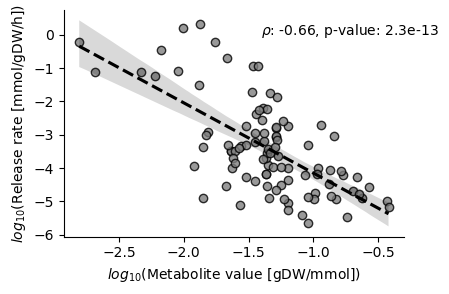

In [33]:
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Metabolite value [gDW/mmol])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Metabolite value [gDW/mmol])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-1.4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_release.pdf')
plt.savefig('value_vs_release.png', dpi = 400, bbox_inches="tight")
plt.show()

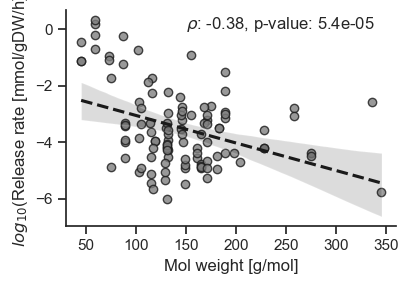

In [34]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df_no_cg_no_nad.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('Mol weight [g/mol]')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['Mol weight [g/mol]', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['Mol weight [g/mol]'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(150, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('mw_vs_release_no_nad.pdf')
plt.savefig('mw_vs_release_no_nad.png', dpi = 400, bbox_inches="tight")

plt.show()

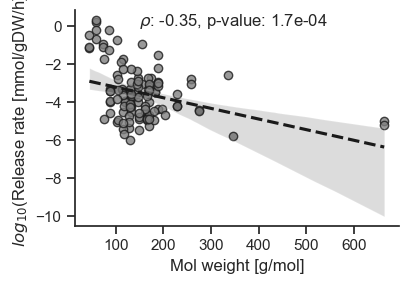

In [35]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('Mol weight [g/mol]')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['Mol weight [g/mol]', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['Mol weight [g/mol]'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(150, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('mw_vs_release.pdf')
plt.savefig('mw_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [36]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log P', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel('log P (solubility in oil/water)')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log P', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log P'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-6, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('logP_vs_release.pdf')
plt.savefig('logP_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

KeyError: "['log P'] not in index"

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
sns.lmplot(data = df_mean.loc[df_mean.Species=='E. coli'], x = 'log10(Intracell. conc. [mM])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Intracell. conc. [mM])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Intracell. conc. [mM])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Intracell. conc. [mM])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-1.4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
# sns.relplot(, col = 'Species - Carbon source', col_wrap=3, hue = 'Metabolite', s = 100, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('conc_vs_release.pdf')
plt.savefig('conc_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [ ]:
df_mean = df.groupby(['Carbon source', 'Species', 'Metabolite']).mean(numeric_only=True)
df_mean.reset_index(inplace=True)
df_mean.replace([-np.inf, np.inf], np.nan, inplace=True)
notnan_idx = ~df_mean[['log10(Turnover [mmol/gDW/h])', 'log10(Rate [mmol/gDW/h])']].isna().any(axis=1)
s_idx = df_mean.Species=='E. coli'
sns.lmplot(data = df_mean.loc[notnan_idx&s_idx,:], x = 'log10(Turnover [mmol/gDW/h])', y = 'log10(Rate [mmol/gDW/h])', line_kws={'color': 'k', 'ls': '--'}, scatter_kws={'color': 'gray', 'edgecolor': 'k', 'alpha':0.8}, aspect=1.4, height=3)
plt.xlabel(r'$log_{10}$(Turnover [mmol/gDW/h])')
plt.ylabel(r'$log_{10}$(Release rate [mmol/gDW/h])')

corr_data = df_mean.loc[df_mean.Species=='E. coli',['log10(Turnover [mmol/gDW/h])', 'log10(Rate [mmol/gDW/h])']]
corr_data = corr_data.loc[~corr_data.isna().any(axis = 1)]

pcorr, ppval = st.pearsonr(corr_data['log10(Turnover [mmol/gDW/h])'], corr_data['log10(Rate [mmol/gDW/h])'])
plt.text(-4, 0, r'$\rho$: {0:.2f}, p-value: {1:.1e}'.format(pcorr, ppval))
plt.savefig('turnover_vs_release.pdf')
plt.savefig('turnover_vs_release.png', dpi = 400, bbox_inches="tight")

plt.show()

In [ ]:
sns.set(font_scale = 1.5, style = 'ticks')
p = sns.relplot(data = df_no_cg, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.map(sns.regplot, 'log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])', scatter = False, color = 'gray')
p.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title='Metabolite class', frameon=True,
)
for lh in p.legend.legend_handles: 
    lh._sizes = [250] 
plt.tight_layout()
# sns.regplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, scatter=False, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_rate.png', dpi = 400, bbox_inches="tight")
plt.savefig('value_vs_rate.pdf', bbox_inches="tight")
plt.show()

In [ ]:
sns.set(font_scale = 1.5, style = 'ticks')
p = sns.relplot(data = df, x = 'log10(Metabolite value [gDW/mmol C])', y = 'log10(Rate [mmol C/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()

In [ ]:
p = sns.relplot(data = df_no_cg, x = 'log10(Metabolite value [gDW/g])', y = 'log10(Rate [g/gDW/h])', col = 'Species - Carbon source', col_wrap=3, hue = 'Compound class', s = 100, facet_kws={'sharex': False, 'sharey': False})
p.map(sns.regplot, 'log10(Metabolite value [gDW/g])', 'log10(Rate [g/gDW/h])', scatter = False, color = 'gray')
p.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(
    p, "lower center",
    bbox_to_anchor=(.5, 1), ncol=6, title='Metabolite class', frameon=True,
)
for lh in p.legend.legend_handles: 
    lh._sizes = [250] 
plt.tight_layout()
# sns.regplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, scatter=False, facet_kws={'sharex': False, 'sharey': False})
plt.savefig('value_vs_rate_g.png', dpi = 400, bbox_inches="tight")
plt.savefig('value_vs_rate_g.pdf', bbox_inches="tight")
plt.show()

In [ ]:
sns.boxplot(data = df.loc[df.Species=='E. coli'], y = 'Compound class', x = 'log10(Rate [g/gDW/h])', order=['Carboxylic acid', 'Phosphorylated sugar', 'Amino acid', 'Nucleosides and nucleotides', 'Other'])
sns.despine()
plt.tight_layout()
plt.savefig('boxplot_rates.png', dpi = 400)
plt.show()

In [ ]:
sns.boxplot(data = df.loc[df.Species=='E. coli'], y = 'Compound class', x = 'log10(Metabolite value [gDW/mmol])', order=['Carboxylic acid', 'Phosphorylated sugar', 'Amino acid', 'Nucleosides and nucleotides', 'Other'])
sns.despine()
plt.tight_layout()
plt.savefig('boxplot_values.png', dpi = 400)
plt.show()

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/mmol])', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/mmol C])', y = 'log10(Rate [mmol C/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})

In [ ]:
sns.lmplot(data = df, x = 'log10(Metabolite value [gDW/g])', y = 'log10(Rate [g/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
plt.show()

In [ ]:
'Metabolite', 'Carbon source',
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])']
xvarsS = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P',
       'log10(Metabolite value [gDW/mmol])', 'log10(Rate [mmol/gDW/h])']

In [ ]:
df['Polar surface area'] = df['Topological Polar Surface Area']

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsL, y_vars=xvarsL, hue = 'Species - Carbon source')
plt.show()

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsS, y_vars=xvarsS, hue = 'Species - Carbon source')
plt.show()

In [ ]:
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS, y_vars=xvarsS, hue = 'Species - Carbon source')

In [ ]:
sns.pairplot(df_no_cg, x_vars=xvarsS, y_vars=xvarsS, 
            kind="reg")

In [ ]:
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS, y_vars=xvarsS, 
            kind="reg")

In [ ]:
sns.set(font_scale = 0.8,style = 'ticks')
sns.pairplot(df_no_cg_no_nad, x_vars=xvarsS[-3:-1], 
            kind="reg", y_vars = ['log10(Rate [mmol/gDW/h])'], palette='tab20', 
             plot_kws={'scatter_kws':{'s':10}, 'color': '#1f77b4'})
plt.savefig('other_factors2.png', dpi = 400)
plt.show()

In [ ]:
sns.lmplot(data = df_no_cg_no_nad, x = 'Mol weight [g/mol]', y = 'log10(Rate [mmol/gDW/h])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
plt.show()

In [ ]:
# sns.lmplot(data=df_no_cg, y = 'log10(Intracellular concentration [mM])', x = 'log10(Metabolite value [gDW/mmol])', col = 'Species - Carbon source', col_wrap=3, facet_kws={'sharex': False, 'sharey': False})
# plt.show()

# Rate distribution

In [ ]:
from scipy import stats as st

In [ ]:
fit = st.fit(st.norm, [x for x in df_no_cg['log10(Rate [mmol/gDW/h])'] if np.isfinite(x)],
             bounds = [[-5, -2], [0, 3]])
print(fit.params)

In [ ]:
fit.plot()
plt.show()

In [ ]:
df_no_cg[['Metabolite', 'Carbon source', 'Species', 'log10(Rate [mmol/gDW/h])','Rate [mmol/gDW/h]']].to_csv('D_rates_and_meta.csv')

In [ ]:
df_no_cg['log10(Rate [mmol/gDW/h])'].to_csv('log10_rates.csv')
df_no_cg['Rate [mmol/gDW/h]'].to_csv('D_rates.csv')

In [ ]:
x = np.linspace(-8, 1, 100)
dist = fit.pxf(x, loc = fit.params[0], scale = fit.params[1])

In [ ]:
fit.params

In [ ]:
sns.set_style('white')
ax = sns.histplot(df_no_cg['log10(Rate [mmol/gDW/h])'], stat='density', palette='tab10', color='C2', bins = 20)
sns.lineplot(x = x, y = dist, ax = ax, color = 'k', ls = '--', label = 'lognormal distribution')
sns.move_legend(ax, loc = 1)
sns.despine()
plt.show()

In [ ]:
# fit.plot(df_no_cg['log10(Rate [mmol/gDW/h])'])
# plt.show()

In [ ]:
sns.histplot(df_no_cg['log10(Rate [mmol/gDW/h])'], color='C0')
plt.show()

# Linear model

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
# idx = df_no_cg.Species == 'B. licheniformis'

In [ ]:
df_ecoli = df.loc[df.Species == 'E. coli']

In [ ]:
# np.isnan(df_no_cg[key]).sum()

In [ ]:
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])', 'Compound class']

In [ ]:
var_explained = {}
for key in xvarsL:
    print(key)
    if key == 'log10(Rate [mmol/gDW/h])':
        continue
    lindf = pd.DataFrame()
    lindf['Y'] = df_ecoli['log10(Rate [mmol/gDW/h])']
    lindf['A'] = df_ecoli[key]
    print(lindf['A'])
    lindf.replace([np.inf, -np.inf], np.nan, inplace=True)
    lindf.dropna(inplace=True)
    # print(np.isnan(lindf['A']).sum())
    res = sm.ols(formula="Y ~ A", data=lindf).fit()
    res.summary()
    print(key, res.rsquared)
    var_explained[key] = res.rsquared_adj

In [ ]:
lindf = pd.DataFrame()
lindf['Y'] = df_ecoli['log10(Rate [mmol/gDW/h])']
lindf['A'] = df_ecoli['log10(Intracell. conc. [mM])']
lindf['B'] = df_ecoli['log10(Metabolite value [gDW/mmol])']
lindf['C'] = df_ecoli['Charge']
lindf['D'] = df_ecoli['Mol weight [g/mol]']
lindf['G'] = df_ecoli['Compound class']
lindf['E'] = df_ecoli['log P']
lindf['F'] = df_ecoli['log10(Turnover [mmol/gDW/h])']
lindf.replace([np.inf, -np.inf], np.nan, inplace=True)
lindf.dropna(inplace=True)
# lindf['F'] = df_no_cg['Mol weight [g/mol]']
# lindf['G'] = df_no_cg['Topological Polar Surface Area']
res = sm.ols(formula="Y ~ A + B + C + G", data=lindf).fit()
print(res.summary())
var_explained['Met. value + Int. conc + charge + compound class'] = res.rsquared_adj
print(var_explained)

In [ ]:
s = res.summary2()
print(s)
s.tables[1].to_csv('linear_model.csv')

In [ ]:
np.sqrt(res.mse_resid)

In [ ]:
np.std(res.resid)

In [ ]:
res.resid

In [ ]:
plt.hist(res.resid, bins=30)
plt.show()

In [ ]:
order = [k for k, v in sorted(var_explained.items(), key=lambda item: item[1])]

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
keys = list(var_explained.keys())
# get values in the same order as keys, and parse percentage values
fig, ax = plt.subplots(1,1, figsize = (9, 4))
vals = list(var_explained.values())
sns.barplot(y=keys, x=vals, color = '#1f77b4', order = order, ax = ax)
plt.xlabel(r'adjusted $R^2$')
sns.despine()
plt.title('Variability of metabolite release rates explained - E. coli')
plt.tight_layout()
plt.savefig('barplot_ecoli.png', dpi = 400)

plt.show()

In [ ]:
sns.set(font_scale = 1, style = 'ticks')
keys = list(var_explained.keys())
# get values in the same order as keys, and parse percentage values
fig, ax = plt.subplots(1,1, figsize = (9, 4))
vals = list(var_explained.values())
sns.barplot(y=keys, x=vals, color = '#1f77b4', order = order, ax = ax)
plt.xlabel(r'adjusted $R^2$')
sns.despine()
plt.title('Variability of metabolite release rates explained - E. coli')
plt.tight_layout()
plt.savefig('barplot_ecoli.png', dpi = 400)

plt.show()

In [ ]:
xvarsL = ['Mol weight [g/mol]', 'Topological Polar Surface Area', 'log10(Intracell. conc. [mM])', 'log P', 'log10(Rate [mmol/gDW/h])','Charge','Phosphate',
       'log10(Metabolite value [gDW/mmol])','log10(Turnover [mmol/gDW/h])']

In [ ]:
df.columns

# Fix mapping

In [ ]:
minfo3 = pd.read_excel('../data/met_info_3.xlsx')
minfo2 = pd.read_csv('../data/met_info_curated_211.csv', encoding = "ISO-8859-1", index_col = 0)

In [ ]:
dic = minfo2.set_index('Metabolite name').to_dict(orient = 'index')

In [ ]:
minfom = pd.merge(left = minfo3, right = minfo2, left_on = 'Metabolite', right_on = 'Metabolite name', how = 'left')

In [ ]:
minfom.to_csv('../data/met_info_3.csv')